# Analysis of excitonic states

In [6]:
%autosave 0
from BigDFT import Logfiles as lf
from BigDFT import Calculators as C
from futile import Yaml
import matplotlib.pyplot as plt
import numpy as np
import scipy.fftpack
import sys
sys.path.insert(0,'../')
import Routine as R
outputpath = 'linear-response/'

Autosave disabled


We read the coupling matrix and dipoles (with the highest given number of virtual orbitals)

In [7]:
nVirtMax = 303
%cd $outputpath
dpath = 'log/TDDFT-Results/transition_dipoles_'+str(nVirtMax)+'.txt'
dipoles = np.loadtxt(dpath)
cpath = 'log/TDDFT-Results/coupling_matrix_'+str(nVirtMax)+'.txt'
Cmat = np.loadtxt(cpath)
%cd ..
Cmat.shape

/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2/linear-response
/media/DATA/RICERCA/LINEAR RESPONSE/LR-nb/POLARIZABILITY/N2


(3030, 3030)

We set the number of empty and virtual states and build the C submatrix with the chosen value of nalpha

In [8]:
numOrb = 5
nalpha = nVirtMax
C_ext,dipoles_ext=R.extract_subset([numOrb],[nVirtMax],Cmat,dipoles,[nalpha])
C_ext.shape

(3030, 3030)

We compute the eigenvalues and vectors of C_ext (linalg.eigh gives the eigenvectors in the transpose form so we peform an explicit transpose to the vectors sorted as row vectors)

In [9]:
E2,C_E2 = np.linalg.eigh(C_ext)
C_E2 = C_E2.T

In [10]:
for ind,e in enumerate(E2):
        isok = np.allclose(C_ext.dot(C_E2[ind]),e*C_E2[ind],atol=1.e-12)
        if not isok: print('Eigenvalue',ind,'is false')
print('Validation terminated')

Validation terminated


We compute the contribution of the virtual states in the lower energy eigenstates of C_ext

In [31]:
reload(R)
numExc = 20
weight = R.alphaWeight(numOrb,nalpha,numExc,C_E2,E2)

Exctation number : 1  energy =  0.268571229762
  virtual state : 1  weight =  0.495473966778
  virtual state : 2  weight =  0.495485240895
1 - sumOverThreshold =  9.041e-03

Exctation number : 2  energy =  0.269882874652
  virtual state : 1  weight =  0.997945825866
1 - sumOverThreshold =  2.054e-03

Exctation number : 3  energy =  0.26988299778
  virtual state : 2  weight =  0.997941930992
1 - sumOverThreshold =  2.058e-03

Exctation number : 4  energy =  0.310030437805
  virtual state : 1  weight =  0.499019882403
  virtual state : 2  weight =  0.499018281491
1 - sumOverThreshold =  1.962e-03

Exctation number : 5  energy =  0.31013846787
  virtual state : 1  weight =  0.499026115967
  virtual state : 2  weight =  0.49902271426
1 - sumOverThreshold =  1.951e-03

Exctation number : 6  energy =  0.327073677418
  virtual state : 2  weight =  0.954379966086
1 - sumOverThreshold =  4.562e-02

Exctation number : 7  energy =  0.327073712498
  virtual state : 1  weight =  0.95437990445
1 - s

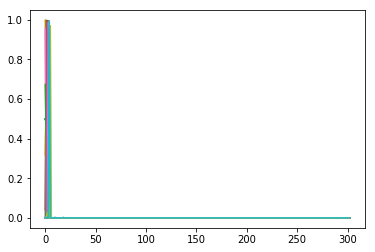

In [10]:
for e in range(numExc):
    plt.plot(weight[e])
plt.show()

In [39]:
for w in weight:
    s = 0.0
    for i in w:
        s+=i
    if np.allclose(s,1.0,atol=1.e-12) == False:
        print 'errore'